# BA 820 Homework 3 (100 Points)

Group Member Names: KAAN KAZANCOGLU

Reminder: you should not be sharing code across groups

Please submit 1) PDF answers and 2) python notebook. Grading will be based on the homework answer write up PDF. Python notebook is for reference and back up only. So please make sure that your all the outputs and answers are clearly visible in the pdf.

## 1 Latent Dirichlet Allocation [60pts]

In this problem, we will use Latent Dirichlet Allocation to perform topic modeling on Amazon Review datasets. In particular, we will take an in-depth look at different aspects of LDA model.

## 1.1 Installation

To perform LDA and visualize, please use Python 3.X. You will also need to install Numpy, Scipy, gensim, nltk, pyLDAvis library. Refer to requirements.txt for more details.
Use the following code to install the labraries.

In [10]:
%pip install gensim
# install gensim for LDA
%pip install nltk 
# install nltk to preprocess sentences
%pip install pyldavis
# to visualize LDA topics
%pip install matplotlib 
# for plotting


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


The cell below tests if the packages we need have been installed correctly, and that we are in the correct environment.

In [1]:
import gensim
import nltk
nltk.download("stopwords")
import pyLDAvis
import matplotlib
%matplotlib inline
import gzip # to unzip the data
import re # to replace punctuations
from nltk.corpus import stopwords # list of stopwords
#The libraries I added:
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaankazancoglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.2 Datasets

You can download the Amazon reviews dataset of Cellphones & Accessory 5-Core Data [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz). Place the downloaded dataset in the same folder as this notebook. You can use the following code to read a datat from GZIp file

In [16]:
# A function to read the zipped data at a specfic path
#
# How to use:
# PATH = "/path/to/file"
# for line in parse(PATH):
#   do something with line
#
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## 1.3 Data Cleaning

Now we will preprocess the data using the following steps:
   1. Remove stopwords
   2. Lower-case all words
   3. Remove words with less than 2 characters
   4. Remove punctuation
   5. Split each sentence into a list of words

In [17]:
# A function to clean a single line of text
def clean_line(line):
    """ Clean stopwords and punction for each line
    
    Args: 
        line (string): one line in file
        
    Returns:
        list(str): a list of all words in the sentence
    """
    punctuationRegex = r'\W+|\d+'
    stopWords = set(stopwords.words('english'))
    line = line.split(" ")
    filtered_content = []
    for word in line:
        #########################
        if word.lower() not in stopWords:
            word = word.lower()
            word = re.sub(punctuationRegex, '', word)
        if word.lower() not in stopWords and len(word) >= 2:
            filtered_content.append(word)
        #########################
    return filtered_content

In [18]:
#Checking to see if clean_title works properly
clean_line("I can only cats dogs wondering imagined should imagined can won't")

['cats', 'dogs', 'wondering', 'imagined', 'imagined']

Finally, we put parse() and clean_line() function together and then extract the first 10,000 reviews into a new text file as your experiment dataset

In [19]:
def read_dataset(fname):
    """ Read the 10000 lines in given dataset into list and clean stop words. 
        
    Args: 
        fname (string): filename of Amazon Review Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    count = 1
    exp_dataset = []
    for review in parse(fname):
        line = review["reviewText"]
        new_line = clean_line(line)
        exp_dataset.append(new_line)
        count += 1
        if count > 10000:
            break
    return exp_dataset

In [20]:
%%time
r = read_dataset("reviews_Cell_Phones_and_Accessories_5.json.gz")
len(r)

CPU times: user 2.8 s, sys: 243 ms, total: 3.04 s
Wall time: 3.04 s


10000

## 1.4 Topic Analysis

**[5pts] Q1.4.1.1** Use topic numbers 3, 6, 9, 12, 15 respectively and print out all topics with 5 words.

For this We will use gensim to train an LDA model. gensim requires the following steps:

Construct a gensim.corpora.dictionary from the dataset
Construct a gensim "corpus" using this dictionary, by mapping each word to an index in the dictionary
Run LDA on this corpus

In [81]:
# Dictionary representation of the documents.
dictionary = corpora.Dictionary(r) # create a gensim dictionary, store it in variable "dictionary"
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(text) for text in r] # create the gensim corpus, store it in variable "corpus"

The function below prints the top num words in each topic for a given model.

In [21]:
def print_topic_words(model,num):
    """ print top words in model topics.
    
    Args: 
        model: LDA model
        
    Returns:
        none
    """    
    #########################
    for i, topic in enumerate(model.print_topics(num_words=num)):
        print ('Topic {} --- {}'.format(i, topic[1]))
    #########################
    return

The following function builds multiple LDA models with number of topics specified in the list `num_topics`.

In [22]:
def build_num_topic_model(dictionary, corpus, num_topics):
    """ Build lda model with given parameters, use print_topic_words to print words
    
    Args: 
        dictionary: dictionary built from dataset
        corpus: corpus built from dataset
        num_topics: list of numbers
        
    Returns:
        none
    """    
    for num_topic in num_topics:
        #########################
        print(num_topic,"Topics:")
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=dictionary,
                                                    num_topics=num_topic, 
                                                    eta = 'symmetric',
                                                    alpha ='symmetric')
        print_topic_words(lda_model,5)
        #########################

In [97]:
build_num_topic_model(dictionary, corpus, [3, 6, 9, 12, 15])

3 Topics:
Topic 0 --- 0.011*"use" + 0.011*"ear" + 0.008*"like" + 0.006*"iphone" + 0.006*"well"
Topic 1 --- 0.020*"phone" + 0.011*"headset" + 0.007*"one" + 0.007*"bluetooth" + 0.007*"great"
Topic 2 --- 0.020*"phone" + 0.015*"case" + 0.014*"one" + 0.009*"great" + 0.009*"iphone"
6 Topics:
Topic 0 --- 0.026*"phone" + 0.012*"screen" + 0.008*"use" + 0.008*"like" + 0.006*"get"
Topic 1 --- 0.017*"headset" + 0.015*"ear" + 0.012*"sound" + 0.011*"bluetooth" + 0.010*"quality"
Topic 2 --- 0.026*"phone" + 0.022*"case" + 0.012*"one" + 0.010*"get" + 0.009*"screen"
Topic 3 --- 0.017*"one" + 0.015*"phone" + 0.007*"good" + 0.007*"cable" + 0.007*"product"
Topic 4 --- 0.025*"case" + 0.015*"iphone" + 0.013*"phone" + 0.009*"one" + 0.008*"good"
Topic 5 --- 0.016*"phone" + 0.015*"charge" + 0.014*"charger" + 0.014*"battery" + 0.013*"works"
9 Topics:
Topic 0 --- 0.037*"phone" + 0.011*"use" + 0.007*"great" + 0.006*"like" + 0.006*"get"
Topic 1 --- 0.012*"one" + 0.011*"great" + 0.011*"good" + 0.010*"phone" + 0.009*

**[3pts] Q1.4.1.2**  Explain what could be interpreted for each topics, and describe the similarity and difference between different topic numbers.

-Based on the topics generated from the LDA model, it appears that the reviews are mainly about electronic devices, specifically phones, phone cases, headsets, chargers, and batteries. Other common keywords found in the topics include screen, sound quality, and bluetooth. It seems that reviews are mainly covering the features and performance of these devices and providing their opinions on their effectiveness, usability, and value for money.

As the number of topics increases, the model becomes more specific and detailed in its grouping of words. For example, in the 12 topic model, there are more specific topics such as "phone battery", "charging", "phone accessories like film and docking", "bluetooth headset and sound quality" and "USB charger and cable". These topics are not present or less prominent in the 3 and 6 topic models. Also, for instance, in the 12-topic model, there are topics related to batteries, phone cases, USB chargers, and even torches. This indicates that the more topics that are used in the model, the more specific and varied the topics can become.

Starting with similarities, we can see that the topic of "phone" is consistently present across all four models. This suggests that discussions about phones are common and prevalent across different contexts. Additionally, we can see that there are some common themes around phone accessories, such as cases, chargers, and headsets, which appear in multiple models.

On the other hand, there are also some notable differences between the models. For example, in the 3-topic model, there is a clear distinction between topics related to phone use and topics related to phone accessories, while in the 9- and 12-topic models, there is more granularity in the discussion of specific types of accessories (e.g. chargers, cases, and headsets). Additionally, the 12-topic model includes some more specific topics, such as "film" and "docking", which do not appear in the other models.


Overall, the main similarity between the different topic numbers is that they all identify groups of words that are related to each other in some way. However, as more topics are added, the model becomes more specific and detailed in its grouping of words.

**[2pts] Q1.4.1.3**  Which topic number would you choose? Explain.

-Higher number of topics can provide more granularity and diversity for the topics above. Based on my output, I would choose the number of topics as 12 as it offers a wider range of topics and potentially more nuanced insights compared to the other models. While using 12, I can get more specific topics which I did not get in lower topic numbers. In 15 topics, I have observed some overlaps between different topics that is why I'm choosing number 12. However, I need to check other features like perplexity and coherence to decide which number of topic best suits my data.

## 1.5 Model Evaluation

**[12 pts] Q1.5.1** Now we investigate two methods to evaluate our model and choose the topic number

1.Perplexity is a measurement of how well a probability distribution or probability model predicts a sample. A low perplexity indicates the probability distribution is good at predicting the sample. We can use model.log_perplexity(document) to evaluate the perplexity of our LDA model.

2.Topic coherence is a one type of interpretability measurement for a topic. It measures if a set of top keywords describe a coherent and singular concept. A good topic will have high topic coherence score. We can use CoherenceModel(model=ldamodel).get_coherence() to calculate it.

Plot Perplexity and topic coherence scores of our LDA model for topic number 3,6,9,12,15,20,50.

The code below trains topic models with different numbers of topics and measures their coherence and perplexity.

In [495]:
# perplexity 
# run different number of topics to get perplexity and coherence value for this model
from gensim.models.coherencemodel import CoherenceModel
def get_measurement_for_model(dictionary, corpus, topic_nums):
    """ Build lda model with given parameters 
    
    Args: 
        dictionary: dictionary built from dataset
        corpus: corpus built from dataset
        topic_nums: a list contains all possible topic number
        
    Returns:
        2 lists: one of perplexities, and one of coherence value
    """  
    perplexity = []
    coherence_value=[]
    for num_topic in topic_nums:
        #########################
        #   - Build model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topic, 
                                           eta = 'symmetric',
                                           alpha ='symmetric')
        #   - Compute and store coherence
        coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus,
                                             dictionary=dictionary, coherence='u_mass')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_value.append(coherence_lda)
        #   - Compute and store perplexity
        perplexity_lda = lda_model.log_perplexity(corpus,total_docs= len(corpus))
        perplexity.append(perplexity_lda)
        #########################
    return perplexity,coherence_value

In [496]:
perplexity, coherence = get_measurement_for_model(dictionary, corpus, [3, 6, 9, 12, 15, 20, 50])

In [497]:
print(perplexity)
print(coherence)

[-7.905933525965366, -7.996643039684271, -8.30467193989768, -8.57175976402896, -8.822069356133456, -9.121941515452475, -11.05889405451974]
[-1.4920459691925236, -2.0262792595583954, -1.7407444682116688, -2.380980455367431, -2.335802396682216, -3.0430227957313205, -4.396026525155082]


We can now plot the coherence and perplexity of each model.

In [491]:
import matplotlib.pyplot as plt

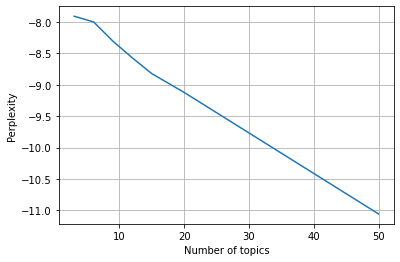

In [498]:
plt.plot([3, 6, 9, 12, 15, 20, 50], perplexity)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.show()

**[2pts] Q1.5.2**  From the above graph what topic number would you choose and why? Is it a good idea to choose the topic number based on perplexity? why or why not?

-Perplexity is a measure of how well the model predicts the test data. In general, a lower perplexity value indicates a better model fit. Based on solely perplexity values, I would choose 50 as it has the lowest perplexity value. However, perplexity is just one metric, it is not always parallel with coherence and interpretability. To evaluate the quality of an LDA model, I need to combine other metrics before deciding which number of topic is best for my LDA model. In a nutshell, while perplexity is a useful measure of model fit, it should not be the only feature for choosing the best topic number. Coherence and interpretability of topics are equally important factors to consider.

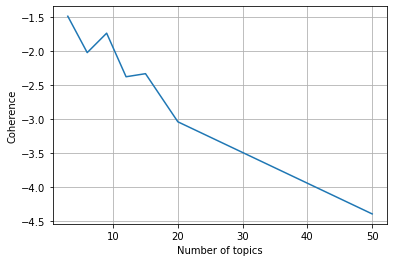

In [499]:
plt.plot([3, 6, 9, 12, 15, 20, 50], coherence)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.show()

**[2pts] Q1.5.3**  From the above graph what topic number would you choose and why?

-We can see that the coherence score tends to decrease as the number of topics increases. This could indicate that the model is not able to effectively capture the structure of the data with more topics. Based on solely coherence scores, I'd choose topic number 9 since it has relatively high coherence compared to other models. The reason I do not go with number 3 is even though it has the highest coherence is, as discussed previously, low topic numbers are not really specific but more general.

**[4pts]Q1.5.4** Compare two methods you implemented in the previous quesions, which one do you think is better and why? In answering, please discuss the actual topics generated.

-When selecting the optimal number of topics one should choose a model that has low perplexity and high coherence. I think neither of them individually is perfect. We need to combine both methods while choosing number of topics. Topic 9 was able to capture topics seperately that includes keywords like bluetooth, charger, screen, cable, headset, iphone, usb, and car. When we use low topic numbers like 3, screen, car, usb are not included in top words. For high topic numbers like 15, we are seeing so many overlaps in topics within each other. Also, for instance, topic 10 in number of topic=15 > "one" + 0.016*"great" + 0.012*"phone" + 0.011*"use" + 0.009*"would" doesnt articulate what the actual topic is thus some topics become meaningless. 

## 1.6 Alpha and Beta in LDA

**[7pts]Q1.6.1** In this problem, we will check the two most important parameters in LDA model: alpha and beta. Alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words.

In [541]:
best_topic_num = 9 # CHANGE THIS

In [543]:
#model 1
model1 = None
#########################
# YOUR CODE HERE
#   - Build model for alpha = 1/num_topic = eta
model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                         id2word=dictionary,
                                         num_topics=best_topic_num, 
                                         eta = 1/best_topic_num,
                                         alpha =1/best_topic_num)

#   - Print top words
print_topic_words(model1,5)

# Print Coherence
print("Coherence for Model 1 is ", CoherenceModel(model=model1, texts=r,
                                             dictionary=dictionary, coherence='c_v').get_coherence())
# Print Perplexity
print("Perplexity for Model 1 is ", model1.log_perplexity(corpus))
#########################

Topic 0 --- 0.043*"great" + 0.022*"works" + 0.021*"price" + 0.021*"product" + 0.012*"good"
Topic 1 --- 0.028*"phone" + 0.013*"iphone" + 0.013*"case" + 0.011*"cable" + 0.011*"use"
Topic 2 --- 0.076*"case" + 0.016*"protection" + 0.014*"good" + 0.013*"phone" + 0.012*"otterbox"
Topic 3 --- 0.013*"charge" + 0.012*"phone" + 0.009*"great" + 0.009*"iphone" + 0.009*"droid"
Topic 4 --- 0.029*"protector" + 0.026*"screen" + 0.013*"film" + 0.012*"bubbles" + 0.011*"protectors"
Topic 5 --- 0.014*"headset" + 0.012*"bluetooth" + 0.010*"one" + 0.010*"use" + 0.009*"iphone"
Topic 6 --- 0.026*"charger" + 0.023*"phone" + 0.011*"works" + 0.011*"samsung" + 0.010*"oem"
Topic 7 --- 0.027*"phone" + 0.011*"one" + 0.009*"get" + 0.008*"screen" + 0.008*"like"
Topic 8 --- 0.013*"headset" + 0.012*"one" + 0.012*"ear" + 0.009*"use" + 0.008*"sound"
Coherence for Model 1 is  0.3144981892009662
Perplexity for Model 1 is  -8.300779483916715


In [545]:
#model 2
model2 = None
#########################
# YOUR CODE HERE
#   - Build model for alpha = 1/2, eta = 1/5
model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                         id2word=dictionary,
                                         num_topics=best_topic_num, 
                                         eta = 1/5,
                                         alpha =1/2)

#   - Print top words
print_topic_words(model2,5)

# Print Coherence
print("Coherence for Model 2 is ",CoherenceModel(model=model2, texts=r,
                                             dictionary=dictionary, coherence='c_v').get_coherence())
# Print Perplexity
print("Perplexity for Model 2 is ", model2.log_perplexity(corpus))
#########################

Topic 0 --- 0.010*"phone" + 0.008*"nokia" + 0.007*"data" + 0.006*"use" + 0.005*"great"
Topic 1 --- 0.018*"phone" + 0.011*"one" + 0.009*"use" + 0.009*"charger" + 0.007*"would"
Topic 2 --- 0.010*"headphones" + 0.009*"case" + 0.009*"bluetooth" + 0.008*"phone" + 0.008*"music"
Topic 3 --- 0.017*"phone" + 0.013*"one" + 0.013*"great" + 0.011*"good" + 0.011*"screen"
Topic 4 --- 0.016*"one" + 0.015*"phone" + 0.011*"great" + 0.010*"product" + 0.008*"like"
Topic 5 --- 0.020*"headset" + 0.014*"ear" + 0.010*"sound" + 0.010*"one" + 0.009*"bluetooth"
Topic 6 --- 0.029*"case" + 0.020*"phone" + 0.009*"would" + 0.009*"screen" + 0.007*"iphone"
Topic 7 --- 0.021*"works" + 0.020*"cable" + 0.017*"work" + 0.010*"usb" + 0.010*"cables"
Topic 8 --- 0.031*"phone" + 0.015*"battery" + 0.009*"get" + 0.008*"use" + 0.007*"like"
Coherence for Model 2 is  0.31512299280274886
Perplexity for Model 2 is  -8.096258463276495


In [546]:
#model 3
model3 = None
#########################
# YOUR CODE HERE
#   - Build model for alpha = 'auto' = eta
model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                         id2word=dictionary,
                                         num_topics=best_topic_num, 
                                         eta = 'auto',
                                         alpha ='auto')

#   - Print top words
print_topic_words(model3,5)

# Print Coherence
print("Coherence for Model 3 is ",CoherenceModel(model=model3, texts=r,
                                             dictionary=dictionary, coherence='c_v').get_coherence())
# Print Perplexity
print("Perplexity for Model 3 is ", model3.log_perplexity(corpus))
#########################

Topic 0 --- 0.009*"phone" + 0.004*"bare" + 0.003*"like" + 0.003*"prompt" + 0.002*"battery"
Topic 1 --- 0.017*"iphone" + 0.015*"phone" + 0.012*"one" + 0.009*"battery" + 0.009*"great"
Topic 2 --- 0.025*"battery" + 0.013*"phone" + 0.010*"one" + 0.010*"charge" + 0.009*"usb"
Topic 3 --- 0.008*"bluetooth" + 0.008*"phone" + 0.007*"headset" + 0.007*"good" + 0.006*"get"
Topic 4 --- 0.016*"ear" + 0.013*"headset" + 0.010*"great" + 0.010*"good" + 0.008*"bluetooth"
Topic 5 --- 0.021*"one" + 0.016*"phone" + 0.010*"signal" + 0.009*"work" + 0.009*"use"
Topic 6 --- 0.021*"cable" + 0.017*"charger" + 0.015*"works" + 0.013*"usb" + 0.013*"phone"
Topic 7 --- 0.021*"phone" + 0.014*"headset" + 0.010*"use" + 0.009*"bluetooth" + 0.009*"like"
Topic 8 --- 0.045*"case" + 0.026*"phone" + 0.017*"screen" + 0.010*"like" + 0.010*"good"
Coherence for Model 3 is  0.3326400494000536
Perplexity for Model 3 is  -8.203319033343872


**[3pts]1.6.2**  Explain how the different alpha and beta values theoretically influence the LDA model. Then describe what you find in the empirical result (e.g difference in topic words and topics)

-Alpha is a hyperparameter that controls the sparsity of the distribution over topics in documents. Beta is also a hyperparameter but it controls the sparsity of the distribution over words in topics. A higher value of alpha implies that the model expects each document to contain more topics, while a lower value of alpha implies that the model expects each document to contain fewer topics. On the contrary, for beta, higher value means that the model expects each topic to contain more words, while a lower value means that the model expects each topic to contain fewer words. In the empirical results, I observed that different alpha and beta values generates different topic keywords.

model1: Alpha and eta are very low. When alpha is low, most of the weight in the topic distribution for the document goes to a single topic. When beta is low, higher weight placed on the top words and lower weight placed on the bottom words for each topic (or more intuitively, topics are composed of few words). For instance, Topic 2 --- 0.076*"case" + 0.016*"protection" + 0.014*"good" + 0.013*"phone" + 0.012*"otterbox", as we can see from topic 2, 'case' has the most weight by a wide margin compared to other words in topic 2. Also, topic 0, topic 2, topic 4 are much more dominant compared to other topics. Aferomentioned topics are related with phone case protectors and phone screen film protectors.


model2: Alpha nad eta are bigger compared to model 1. When alpha is high, The weight is much more evenly distributed across the topics. When eta is high, model places relatively less weight on the top words and more weight on the bottom words. Thus high eta results in topics that have a smoother distribution of weight across all the words in the vocabulary. For instance, Topic 7 --- 0.021*"works" + 0.020*"cable" + 0.017*"work" + 0.010*"usb" + 0.010*"cables", as we can see from topic 7, all words are almost equally weighted. Also, topics are equally important across the document, which means Model 2 covers a broader range of topics including phone features (e.g., battery, screen) and accessories (e.g., case, headphones).


model3: In auto, model automatically estimated the values of these hyperparameters using empirical Bayes method based on the data. Overall, the topics are more like the combination of first and second model, so it was more balanced compared to model1 and model2.

## 1.7 LDA on a short text dataset

**[10pts]1.7.1** In this part, we will read a dataset from twitter and build a LDA model. On Windows, download and unzip the dataset from [this link](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip). Place the downloaded dataset in the same folder as this notebook. Use the first 10,000 lines in the "training.1600000.processed.noemoticon.csv" file. 

In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip # Linux and OSX only
!unzip trainingandtestdata.zip # Linux and OSX only

URL transformed to HTTPS due to an HSTS policy
--2023-03-04 18:36:24--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: 'trainingandtestdata.zip.4'

trainingandtestdata 100%[===================>]  77.59M  27.3MB/s    in 2.8s    

2023-03-04 18:36:27 (27.3 MB/s) - 'trainingandtestdata.zip.4' saved [81363704/81363704]

Archive:  trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
!head -n 10000 training.1600000.processed.noemoticon.csv > twitter.csv # Linux and OSX only

In [4]:
import pandas as pd
df = pd.read_csv("twitter.csv",header=None,encoding="utf-8")
df[5][2]

'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

In [3]:
def read_twitter(fname):
    """ Read the given dataset into list and clean stop words. 
    
    Args: 
        fname (string): filename of Twitter Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    ########################
    stopword_en = nltk.corpus.stopwords.words('english')
    stopword_es = nltk.corpus.stopwords.words('spanish')
    stopword = stopword_en + stopword_es
    punctuationRegex = r'\W+|\d+'
    twt = []
    ########################
    twitter = []
    with open(fname,encoding="utf-8") as f:
        for line in f:
            ########################
            tweet = line.split(",")[5:]
            tweet = "".join(tweet)
            tweet = tweet.split(" ")
            for word in tweet:
                word = nlp(word)
                lemmas = [word.lemma_ for word in word]
                for word in lemmas:
                    if word.lower().startswith('@') or word.lower().startswith('#') or word.lower().startswith('http'):
                        continue
                    if word.lower() not in stopword:
                        word = re.sub(punctuationRegex, '', word)
                    if word.lower() not in stopword and len(word) >= 2:
                        word = word.lower()
                        twt.append(word)
            twitter.append(twt)
            twt = []       
            ########################
    return twitter

In [4]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
twitter = read_twitter('twitter.csv')

CPU times: user 3min 49s, sys: 988 ms, total: 3min 50s
Wall time: 3min 50s


In [5]:
len(twitter)

10000

In [6]:
from gensim.corpora.dictionary import Dictionary

twitter_dictionary = Dictionary(twitter) # TODO: build dictionary
twitter_corpus = [twitter_dictionary.doc2bow(doc) for doc in twitter] # TODO: build corpus for model

In [10]:
%%time
########################
# YOUR CODE HERE
twit_model = gensim.models.ldamodel.LdaModel(corpus = twitter_corpus,
                                             id2word = twitter_dictionary, 
                                             num_topics = 9, 
                                             alpha = 'auto',
                                             eta = 'auto')

print_topic_words(twit_model, 5)

########################

Topic 0 --- 0.035*"get" + 0.018*"go" + 0.012*"week" + 0.012*"time" + 0.011*"work"
Topic 1 --- 0.026*"day" + 0.016*"go" + 0.016*"work" + 0.013*"today" + 0.011*"week"
Topic 2 --- 0.033*"go" + 0.013*"want" + 0.013*"get" + 0.011*"back" + 0.010*"bed"
Topic 3 --- 0.019*"really" + 0.018*"get" + 0.017*"want" + 0.015*"like" + 0.014*"know"
Topic 4 --- 0.038*"work" + 0.021*"go" + 0.015*"get" + 0.014*"today" + 0.013*"love"
Topic 5 --- 0.034*"get" + 0.022*"go" + 0.020*"feel" + 0.017*"sick" + 0.017*"snow"
Topic 6 --- 0.013*"good" + 0.012*"one" + 0.010*"go" + 0.010*"new" + 0.009*"like"
Topic 7 --- 0.025*"work" + 0.022*"go" + 0.014*"day" + 0.014*"one" + 0.013*"sad"
Topic 8 --- 0.020*"get" + 0.019*"wish" + 0.018*"sorry" + 0.018*"miss" + 0.016*"go"
CPU times: user 2.62 s, sys: 23.6 ms, total: 2.64 s
Wall time: 2.64 s


## 1.8 LDA visualization

**[10pts]1.8.1** We will now visualize the LDA output using pyLDAvis. PyLDAVis shows the following:

   1. The distances between topics, as a map in 2-D space.
   2. The variance in the topic-word distribution, as the size of a circle in this map.
   3. The most "salient" terms in each topic.

In [23]:
sentences = read_dataset("reviews_Cell_Phones_and_Accessories_5.json.gz")[:1000] # CHANGE TO YOUR DATASET

In [24]:
%%time
import pyLDAvis.gensim

CPU times: user 9.45 ms, sys: 4.76 ms, total: 14.2 ms
Wall time: 14.8 ms


In [25]:
%%time
data = None
PLDA_dic = corpora.Dictionary(sentences)  # create a gensim dictionary, store it in variable "dictionary"
PLDA_corp = [PLDA_dic.doc2bow(text) for text in sentences]


lda_model = gensim.models.ldamodel.LdaModel(corpus = PLDA_corp,
                                            id2word = PLDA_dic,
                                            num_topics = 9, 
                                            alpha = 'auto',
                                            eta= 'auto')


data = pyLDAvis.gensim.prepare(lda_model, PLDA_corp, PLDA_dic, mds='mmds')
########################

/Users/kaankazancoglu/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


CPU times: user 1.72 s, sys: 221 ms, total: 1.94 s
Wall time: 5.49 s


In [26]:
pyLDAvis.enable_notebook()
pyLDAvis.display(data)

# 2.word2Vec [40pts]


In this problem, we use Amazon Review Dataset to perform Word2Vec and Doc2Vec to extract insights relevant for e-commerce business. For this question, download and use the dataset [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz||reviews_Electronics_5.json.gz).

## 2.1 Data Cleaning



The following code reads the data from a GZIP file.

In [5]:
# A function to read the zipped data at a specfic path
#
# How to use:
# PATH = "/path/to/file"
# for line in parse(PATH):
#   do something with line
#
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

We will now read the data and preprocess it using the following steps:

   1. Remove stopwords
   2. Lower-case all words
   3. Remove words with less than 2 characters
   4. Remove punctuation
   5. Split each sentence into a list of words

   And finally extract 10000 reviews.

In [488]:
# A function to clean a single line of text
def clean_line(line):
    """ Clean stopwords and punction for each line
    
    Args: 
        line (string): one line in file
        
    Returns:
        list(str): a list of all words in the sentence
    """
    line = line.split(" ")
    filtered_content = []
    for word in line:
        #########################
        if word.lower() not in stopWords:
            word = word.lower()
            word = re.sub(punctuationRegex, '', word)
        if word not in stopWords and len(word) >= 2:
            filtered_content.append(word)
        #########################
    return filtered_content

def read_dataset(fname):
    """ Read the 100000 lines in given dataset into list and clean stop words. 
        
    Args: 
        fname (string): filename of Amazon Review Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    count = 0
    exp_dataset = []
    for review in parse(fname):
        line = review["reviewText"]
        #to see the raw lines
        print(line)
        new_line = clean_line(line)
        exp_dataset.append(new_line)
        count += 1
        if count > 100000:
            break
    return exp_dataset    

In [10]:
%%time
stopWords = set(stopwords.words('english'))
punctuationRegex = r'\W+|\d+'
r = read_dataset("reviews_Electronics_5.json.gz")
r[:1]

CPU times: user 18.9 s, sys: 602 ms, total: 19.5 s
Wall time: 19.5 s


[['got',
  'gps',
  'husband',
  'otr',
  'road',
  'trucker',
  'impressed',
  'shipping',
  'time',
  'arrived',
  'days',
  'earlier',
  'expected',
  'within',
  'week',
  'use',
  'however',
  'started',
  'freezing',
  'could',
  'glitch',
  'unit',
  'worked',
  'great',
  'worked',
  'work',
  'great',
  'normal',
  'person',
  'well',
  'trucker',
  'option',
  'big',
  'truck',
  'routes',
  'tells',
  'scale',
  'coming',
  'ect',
  'love',
  'bigger',
  'screen',
  'ease',
  'use',
  'ease',
  'putting',
  'addresses',
  'memory',
  'nothing',
  'really',
  'bad',
  'say',
  'unit',
  'exception',
  'freezing',
  'probably',
  'one',
  'million',
  'thats',
  'luck',
  'contacted',
  'seller',
  'within',
  'minutes',
  'email',
  'received',
  'email',
  'back',
  'instructions',
  'exchange',
  'impressed',
  'way',
  'around']]

**[3pts]2.2.1** In this question, first we will build a Word2Vec model using ginsim using size=300, min_count=40, win- dow=10, negative=10, max_vocab_size=10000. Train the model for 30 epochs.

In [38]:
%%time
from gensim.models import Word2Vec
# YOUR CODE HERE
w2v = gensim.models.word2vec.Word2Vec(sentences=r,vector_size=300,min_count=40,
                                      window=10,negative=10,max_vocab_size=10000)
w2v.train(r, total_examples=w2v.corpus_count,epochs=30)

#w2v = gensim.models.KeyedVectors.load_word2vec_format(r, binary=True)


CPU times: user 17min 25s, sys: 4.29 s, total: 17min 29s
Wall time: 5min 57s


(133138401, 163409010)

**[2pts]2.2.2** Use model.wv.doesnt_match to find a word in ["Canon","Nikon","junk"] that does not

belong.

In [39]:
# YOUR CODE HERE ["Canon", "Nikon", "junk"]
word_vectors = w2v.wv
word_vectors.doesnt_match(["Canon", "Nikon", "junk"])

'junk'

**[3pts]2.2.3** Come up with 3 other word lists and apply the above function. Explain your observation.

In [552]:
# write your code here
word_vectors.doesnt_match(["Burger King", "McDonalds","pen"])

'pen'

-I used Berger King, Mcdonalds, and pen. As expected, pen does not belong to be in the same group with the two of the well-known fastfood chains.

**[2pts]2.2.4** What are some tasks in e-commerce that can be solved with this simple function?

-This simple function can be implemented in Amazon search engines for help customers to find what they looking for easily after typing down couple of keywords. Also it can disect the relevant words and excludes the ones that are not really relevant given a specific prompt. More specifically, it can be used to identify irrelevant products in a search query or to identify and remove outliers in a dataset. For product recommendations, it can also be used to identify items that are not related to the user's interests or purchase history.

## 2.3 Build a doc2vec model

**[15 pts] 2.3.1**  Each review is marked by other customers as “helpful” or not. The "helpful: [a, b]" item in each review is (a) the number of people who marked the review as helpful, and (b) the total number of people who have marked the review as helpful or unhelpful. The "helpfulness" score of a review can be calculated as a/b. Define a "helpful" review as one with helpfulness score >= 0.8. Given a review that is only slightly helpful, could we find textually similar reviews but have higher helpfulness? Build Doc2Vec model with gensim on review data. Use product ID “B00006I5WJ” and ReviewerID with “A14453U0KFWF31” as an example, find top 5 helpful reviews of the same product with similarity score above 0.8. 

In [507]:
import os
def read_reviewers_data(fname, min_count=0):
    '''
    Save all reviews into their own product asin files.
    Make sure you have 'product' folder when you run this answer.
    In each file, you can choose your own log structure. In this answer, log strucutre is like 
        "reviewText"\t"reviewerID"\t"helpful"
    Args: 
        fname: dataset file path
        min_count: minimum number of reviews of a product
    Returns:
        none
    '''
    if not os.path.isdir('product'):
        os.makedirs('product')
    asin_list = []
    tmp_list = []
    last_asin = ""
    j = 0
    for i in parse(fname):
        if last_asin != i['asin']:
            if len(tmp_list) > min_count:
                f = open("product/" + last_asin+".txt", 'w')
                for one in tmp_list:
                    f.write(one)
                f.close()
            tmp_list = []
            last_asin = i['asin']
        tmp_list.append(i["reviewText"] + '\t' + i["reviewerID"] +
                    '\t' + handle_helpful(i["helpful"]) + "\n")
        j += 1
        if j > 100000:
            break
    
def handle_helpful(helpful):
    '''
    Helper function for helpful_score calculate
    Args: 
        helpful: list. The first element is the number of people think this is helpful. The second element
            is the total number of people evaluate this comment
    Returns:
        String: number represent helpfulness
    '''
    if helpful[1] != 0:
        helpfulness = 1.0 * helpful[0] / helpful[1]
        return str(helpfulness)
    else:
        return str(0)

In [508]:
read_reviewers_data("reviews_Electronics_5.json.gz")


In [509]:
class TaggedReviewDocument(object):
    '''
    This class could save all products and review information in its dictionary and generate iter for TaggedDocument
        which could used for Doc2Vec model
    '''
    def __init__(self, dirname):
        self.dirname = dirname
        self.helpfulness = {}  # key:reviewerID value:helpfulness
        self.product = {}      # key:asin value:reviewerID
        self.asin = []

    def __iter__(self):
        for filename in os.listdir(self.dirname):
            asin_code = filename[:-4] #delete ".txt"
            self.product[asin_code] = []
            self.asin.append(asin_code)
            for line in enumerate(open(self.dirname + "/" + filename)):
                line_content = line[1].split("\t")
                self.product[asin_code].append(line_content[1])
                self.helpfulness[line_content[1]] = float(line_content[2])
                yield TaggedDocument(clean_line(line_content[0]), [line_content[1], line_content[2]])


In [510]:
documents = TaggedReviewDocument("product")
documents

In [511]:
%%time
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
# YOUR CODE HERE

model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=30)
#target_vector = model.infer_vector(nltk.word_tokenize(target_review))


CPU times: user 20min 44s, sys: 1min 25s, total: 22min 10s
Wall time: 14min 44s


In [462]:
model

## Find similar reviews

In [573]:
import csv

def find_similar_reviews(asin,reviewer_id):
    '''
    If one review is similar to the specefic review and it is much helpful, save it to a list
    Args: 
        asin: product asin
        reviewer_id: the specific review
    Returns:
        list of reviewer id
    '''
    result = []
    ########################
    lst = []
    sim = 0
    

    with open("product/" +asin+".txt", mode='r') as product_file:
        reader = csv.reader(product_file, delimiter='\t')
        for r in reader:
            #using for loop to get each review that belongs to 
            #specific asin code which is ('B00006I5WJ')
            (reviewText, reviewerID, helpscore) = r
            #applying conditions like having helpscore greater than 0.8
            #and for not getting the same reviewer ID ('A14453U0KFWF31')
            if float(helpscore) > 0.8 and reviewerID != reviewer_id:
                sim = model.dv.similarity(reviewerID, reviewer_id)
                #if similarity score of a specific review belongs to
                #to same product is higher than 0.8, append it to empty list
                if sim > 0.8:
                    lst.append((reviewerID, sim))
    
    cnt = 0
    #sorting the list of key value pairs
    #in decreasing order to get the top 5 in first five iterations:
    lst = sorted(lst, key = lambda s: s[1], reverse = True)
    for idx, sim in lst:
        if cnt < 5:
            result.append((idx, sim))
            cnt = cnt+1
    ########################
    return result

In [574]:
find_similar_reviews('B00006I5WJ','A14453U0KFWF31')

[('AOUKRECWP828A', 0.85026777),
 ('A6FIAB28IS79', 0.83004725),
 ('A5C7KD02LS69I', 0.8196159),
 ('AGITH5SMFTBOB', 0.80659777),
 ('A3I4TQNEO4G6LT', 0.80619234)]

## 2.4 Build a doc2vec model using product descriptions


**[10pts]2.4.1** Use product descriptions (located in meta data  [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz)) to build a Doc2Vec model. When building the doc2vec model, use vector_size=100, window=15, min_count=5, max_vocab_size=1000, and train it for 1 epoch.

In [28]:
def read_product_description(fname):
    '''
    Load all product descriptions
    Args: 
        fname: dataset file path
    Returns:
        dict: key is asin, value is description content
    '''
    result = {}
    for i in parse(fname):
        try:
            if "Camera & Photo" in i["categories"][0]:
                result[i["asin"]]=i["description"]
        except:
            continue
    return result

In [29]:
class TaggedDescriptionDocument(object):
    '''
    This class could save all products and review information in its dictionary and generate iter for TaggedDocument
        which could used for Doc2Vec model
    '''
    def __init__(self, descriptondict):
        self.descriptondict = descriptondict
        

    def __iter__(self):
        for asin in self.descriptondict:
            for content in self.descriptondict[asin]:
                yield TaggedDocument(clean_line(content), [asin])


In [314]:
description_dict = read_product_description("meta_Electronics.json.gz")
des_documents = TaggedDescriptionDocument(description_dict)

In [30]:

# YOUR CODE HERE

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# A function to replace 'new lines' in the text with space and to remove 'returns'.
def clean_text(text):
    cleaned_text = text.lower().replace('\n',' ').replace('\r','')
    return cleaned_text

# A function to generate tagged documents, a list that contains key-value pairs
# of cleaned version of product description and their corresponding product asin codes.
def create_tagged_documents(description_dict):
    tagged_documents = []
    for asin in description_dict:
        tagged_documents.append(TaggedDocument(words=clean_text(description_dict[asin]).split(), tags=[asin]))
    return tagged_documents

    
description_dict = read_product_description("meta_Electronics.json.gz")

tagged_documents = create_tagged_documents(description_dict)

model = Doc2Vec(vector_size = 100, window=15, min_count = 5, max_vocab_size = 1000, epochs =1)
model.build_vocab(tagged_documents)
model.train(tagged_documents,total_examples=model.corpus_count, epochs = model.epochs)

**[5pts]2.4.2** Find the most similar product for Canon EOS 5D (asin:B0007Y791C) not made by Canon.

In [37]:
import json
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

product_name = ""
product_description = ""

for asin in description_dict:
    if asin == "B0007Y791C":
        product_name = description_dict[asin]
        product_description = clean_text(product_name)
        break
# Vector representation for CANON EOS 5D
vector = model.infer_vector(product_description.split())
# Cosine similarities
similar_products = model.docvecs.most_similar([vector],topn=len(model.docvecs))

most_similar_product = None
for product in similar_products:
    asin = product[0]
    for p in description_dict:
        #filtering out the products made by Canon to get the most 
        #similar product that is not made by Canon
        if p == asin and 'Canon' not in description_dict[p]:
            most_similar_product = asin
            break
    if most_similar_product is not None:
        break

/var/folders/qr/b2njs26s0wgc0pzwtq_b3t440000gn/T/ipykernel_79666/1821483855.py:15: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_products = model.docvecs.most_similar([vector],topn=len(model.docvecs))
/var/folders/qr/b2njs26s0wgc0pzwtq_b3t440000gn/T/ipykernel_79666/1821483855.py:15: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_products = model.docvecs.most_similar([vector],topn=len(model.docvecs))


In [38]:
print('Most similar product to Canon EOS 5D, not made by Canon is',most_similar_product)
# Exact product name is Nikon D3200 Digital SLR Camera &amp

Most similar product to Canon EOS 5D, not made by Canon is B007X47WGG
